# Machine Learning Engineering Nanodegree Capstone Project

## Project Overview

This project aims to create a classifier to recognise characters in natural scene images using a subset of the Chars74K dataset and a Convolutional neural network (CNN). 

See the **Capstone Proposal** [here](capstone_proposal.pdf) 

---

## Dataset 

The project uses a subset of the Chars74 dataset, the nature of dataset can be read about [here](http://personal.ee.surrey.ac.uk/Personal/T.Decampos/papers/decampos_etal_visapp2009.pdf).

The [Chars74K](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/) dataset contains:
* 7705 characters obtained from natural images
* 3410 hand drawn characters using a tablet PC
* 62992 synthesised characters from computer fonts

#### Whrere to get the dataset

* The download `EnglishImg.tgz` contains images of characters from natural scenes. 
* The download `ListsTXT.tgz` and file `list_English_Img.m` contains the information of the data structure but in the "M" format. 
* This has been translated here into a simple csv, for an initial exploration of class distribution, with the columns:
    * **ALLlabels**: class label for each sample
    * **ALLnames**: sub-directory and name of the image for each sample

This project will initially focus on the classification of the 7705 characters obtained from natural scene images.

In [6]:
import pandas as pd
from collections import Counter
import numpy as np
# Import supplementary code from visuals.py
import functions as vs

import matplotlib.pyplot as plt
from io import StringIO

import os
import math
from scipy.misc import imread, imsave, imresize
# ignore deprecation warnings
import warnings
warnings.filterwarnings('ignore')

## Data Exploration

In [7]:
data = pd.read_csv('details/ListsGoodImg.csv')
data.head()

,ALLlabels,ALLnames
0,1,GoodImg/Bmp/Sample001/img001-00001
1,1,GoodImg/Bmp/Sample001/img001-00002
2,1,GoodImg/Bmp/Sample001/img001-00003
3,1,GoodImg/Bmp/Sample001/img001-00004
4,1,GoodImg/Bmp/Sample001/img001-00005


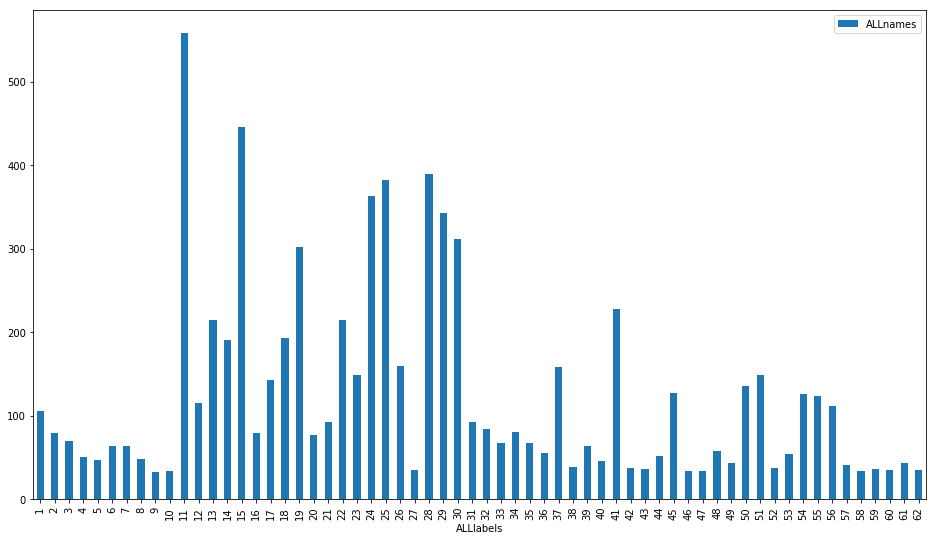

In [5]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = [16,9]
data.groupby('ALLlabels').count().plot.bar(ylim=0)

As can seen above the clases in the dataset are not evenly distrbuted. The classses correspond to:

| Label  | Class |
| ---    |  ---  |
| 1-10   | 0 - 9 |
| 11-36  | A - Z |
| 37-62  | a - z |

### Exploring the images

* The `GoodImg` folder is structured such that the `Bmp` folder contains samples of the 62 different classes each in their own folder such as `Sample001`.
* The code below shows all the photos from `Sample001` with is different photos of the character 0.
      
 

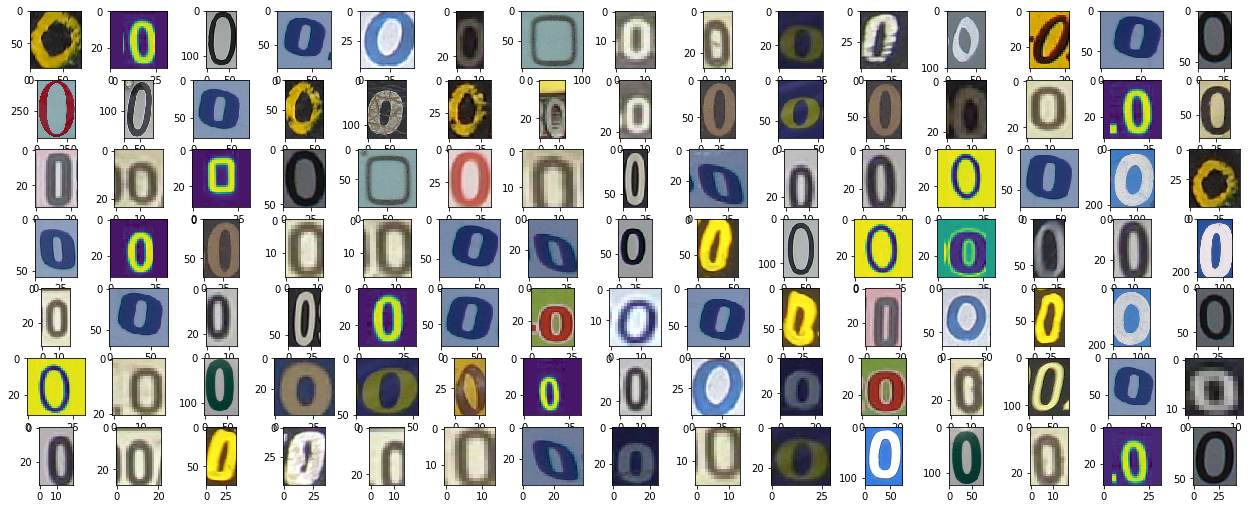

In [8]:
import glob
import matplotlib.image as mpimg
%matplotlib inline
images = []
for img_path in glob.glob('img/GoodImg/Bmp/Sample001/*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(22,10))
columns = 15
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

### Preprocessing

See all pre-processing code and steps taken [here](pre_processing.ipynb)<sup>1</sup>

### Show sample processed images

Show how the sample images for character 0 have changed after simple pre-processing

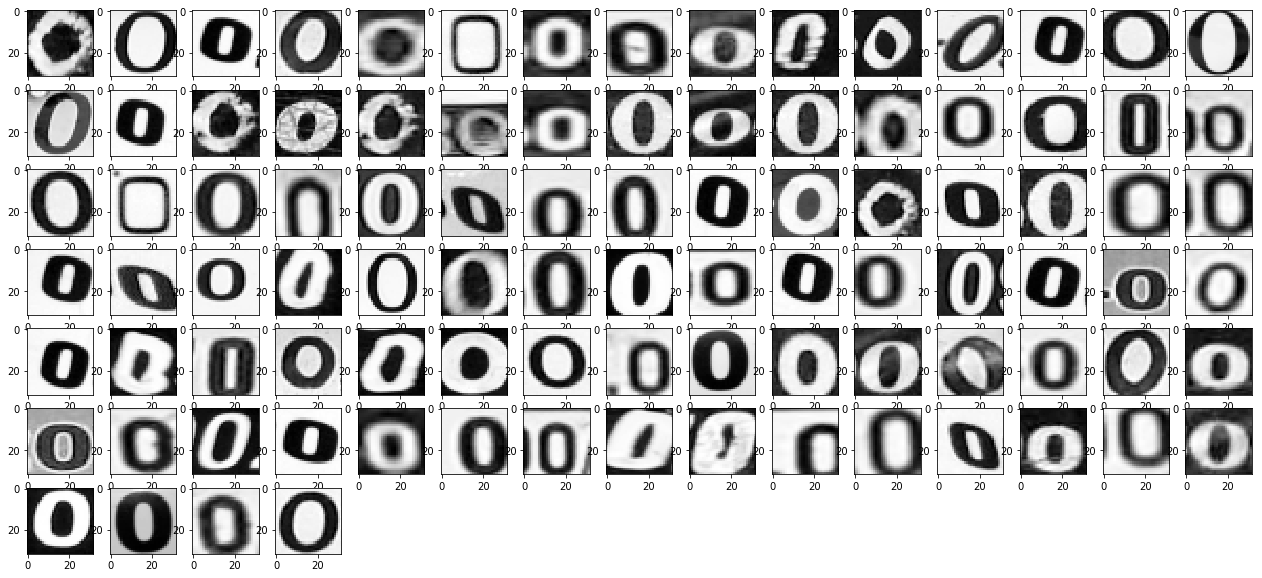

In [6]:
images = []
for img_path in glob.glob('data/train_preproc_32_32/img001-*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(22,10))
columns = 15
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    # By default matplotlib uses a colormap which maps intensities to colors. 
    # `cmap='Greys_r' is used to show the image
    plt.imshow(image, cmap='Greys_r')

### Load data and labels

In [9]:
X_train_all = np.load("data/training_preproc_32_32.npy")
Y_train_all = np.load("data/trainingLabels.npy")

X_test_all = np.load("data/test_preproc_32_32.npy")
Y_test_all = np.load("data/testLabels.npy")

In [10]:
print('There are %d training images.' % len(X_train_all))
print('There are %d test images.' % len(X_test_all))

There are 6905 training images.
There are 800 test images.


### Data Augmentation<sup>2</sup>

We can apply some augmentation to increase the size of the training set with "augmented" images. These augmentations are random transformations applied to the initial data to product a modified version of it. Data augmentation lets us artificially increase the number of training examples by applying transformations, adding noise etc.<sup>3</sup>

Keras comes with a class for image augmentation [ImageDataGenerator](https://keras.io/preprocessing/image/). First we create an image generator by calilng the `ImageDataGenerator()` function and pass the list of paramaters describing the alterations that we want it to perform on the images.<sup>4</sup>. We the call the `fit_generator()` function on the image generator which will apply changes to the images batch by batch. 

This shows how data augmentation can be applied in the next step:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
* `shear_range` is for randomly applying shearing transformations
* `zoom_range` is for randomly zooming inside pictures
* `horizontal_flip` is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [18]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='reflect')

#load one of the pre-processed training images
img = load_img('data/train_preproc_32_32/img001-00001.png')
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)  

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', 
                          save_prefix='example',
                          save_format='png'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

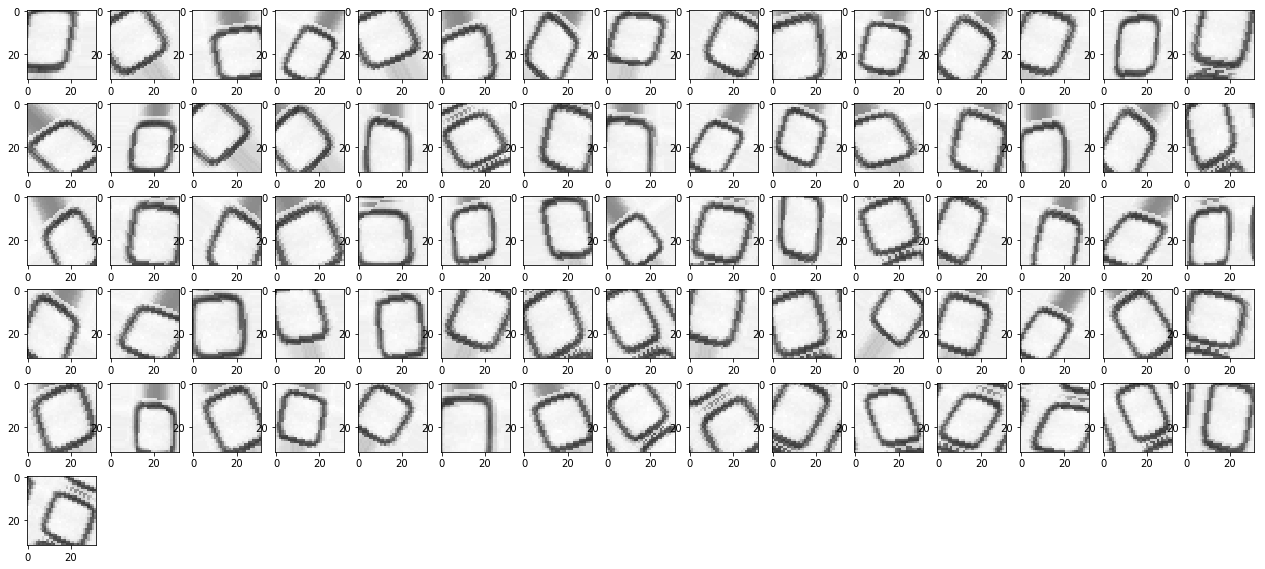

In [19]:
images = []
for img_path in sorted(glob.glob('preview/*.png')):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(22,10))
columns = 15
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image, cmap='Greys_r')

## CNN Model

The CNN architecutre investigated here follows the VGG style convolutional network. The final best network for VGGNet contains 16 CONV/FC layers and an architecture that only performs 3x3 convolutions and 2x2 pooling from the beginning to the end. <sup>5</sup>

* INPUT [32x32x1] will hold the raw pixel values of the image, in this case an image of width 32, height 32, and with one color channel as the images were flattened to grayscale.
* CONV layer will compute the output of neurons that are connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume. 
* RELU layer will apply an elementwise activation function, such as the max(0,x) thresholding at zero. 
* POOL layer will perform a downsampling operation along the spatial dimensions.
* FC (i.e. fully-connected) layer will compute the class scores, where each of the 62 numbers and letters correspond to a class score. 

Architecture Overview:

* Conv2D: 3x3 kernels | 128 maps | init='he_normal' | relu | input shape = (1,32,32) 
* Conv2D: 3x3 kernels | 128 maps | init='he_normal' | relu 
* MaxPooling2D | 2x2 pool size 
* Conv2D: 3x3 kernels | 256 maps | init='he_normal' | relu 
* Conv2D: 3x3 kernels | 256 maps | init='he_normal' | relu 
* MaxPooling2D | 2x2 pool size |
* Conv2D: 3x3 kernels | 512 maps | init='he_normal' | relu 
* Conv2D: 3x3 kernels | 512 maps | init='he_normal' | relu 
* Conv2D: 3x3 kernels | 512 maps | init='he_normal' | relu 
* MaxPooling2D | 2x2 pool size | 
* Flatten layer
* Fully Connected | 2048 units | relu
* Dropout (0.5)
* Fully Connected | 2048 units | relu
* Dropout (0.5)
* Fully Connected | 62 units | softmax 

In [11]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.cross_validation import train_test_split
from keras.callbacks import ModelCheckpoint, History  
import time

from keras import backend as K
K.set_image_dim_ordering('th')

epochs = 100
batch_size = 128

In [16]:
# Split in train and validation sets
X_train, X_val, Y_train, Y_val = \
        train_test_split(X_train_all, Y_train_all, test_size=0.20, stratify=np.argmax(Y_train_all, axis=1))
    
# Parametrize the image augmentation class
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest') 
    
# Define the CNN architecture
model = Sequential()
model.add(Conv2D(128, 3, 3, border_mode='same', init='he_normal', activation = 'relu', input_shape=(1, 32, 32)))
model.add(Conv2D(128, 3, 3, border_mode='same', init='he_normal', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, 3, 3, border_mode='same', init='he_normal', activation = 'relu'))
model.add(Conv2D(256, 3, 3, border_mode='same', init='he_normal', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, 3, 3, border_mode='same', init='he_normal', activation = 'relu'))
model.add(Conv2D(512, 3, 3, border_mode='same', init='he_normal', activation = 'relu'))
model.add(Conv2D(512, 3, 3, border_mode='same', init='he_normal', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(2048, init='he_normal', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(2048, init='he_normal', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(62, init='he_normal', activation = 'softmax'))

In [17]:
model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', monitor='val_acc',
                               verbose=1, save_best_only=True, save_weights_only=True)

# Make the model learn using the image generator
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                        samples_per_epoch=len(X_train),
                        nb_epoch=epochs, 
                        validation_data=(X_val, Y_val),
                        callbacks=[checkpointer],
                        verbose=0)

Epoch 00000: val_acc improved from -inf to 0.07241, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00001: val_acc did not improve
Epoch 00002: val_acc did not improve
Epoch 00003: val_acc did not improve
Epoch 00004: val_acc did not improve
Epoch 00005: val_acc improved from 0.07241 to 0.15713, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00006: val_acc improved from 0.15713 to 0.21796, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00007: val_acc improved from 0.21796 to 0.29254, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00008: val_acc improved from 0.29254 to 0.36206, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00009: val_acc did not improve
Epoch 00010: val_acc improved from 0.36206 to 0.37219, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00011: val_acc improved from 0.37219 to 0.37944, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00012: 

In [20]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')
    
test_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in X_test_all]
   
# report test accuracy
test_accuracy = 100*np.sum(np.array(test_predictions)==np.argmax(Y_test_all, axis=1))/len(test_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 72.3750%


## Model Evaluation

In [21]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 32, 32)       1280      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 32, 32)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 16, 16)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 256, 16, 16)       295168    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 16, 16)       590080    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 256, 8, 8)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 512, 8, 8)         1180160   
__________

#### Show performance of the model during the different epochs<sup>6</sup>

dict_keys(['loss', 'val_acc', 'val_loss', 'acc'])


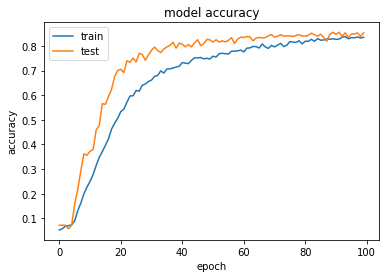

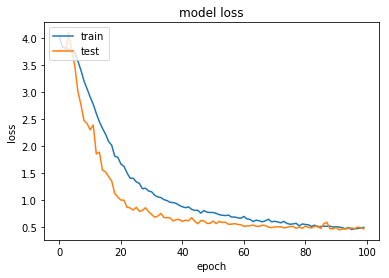

In [22]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

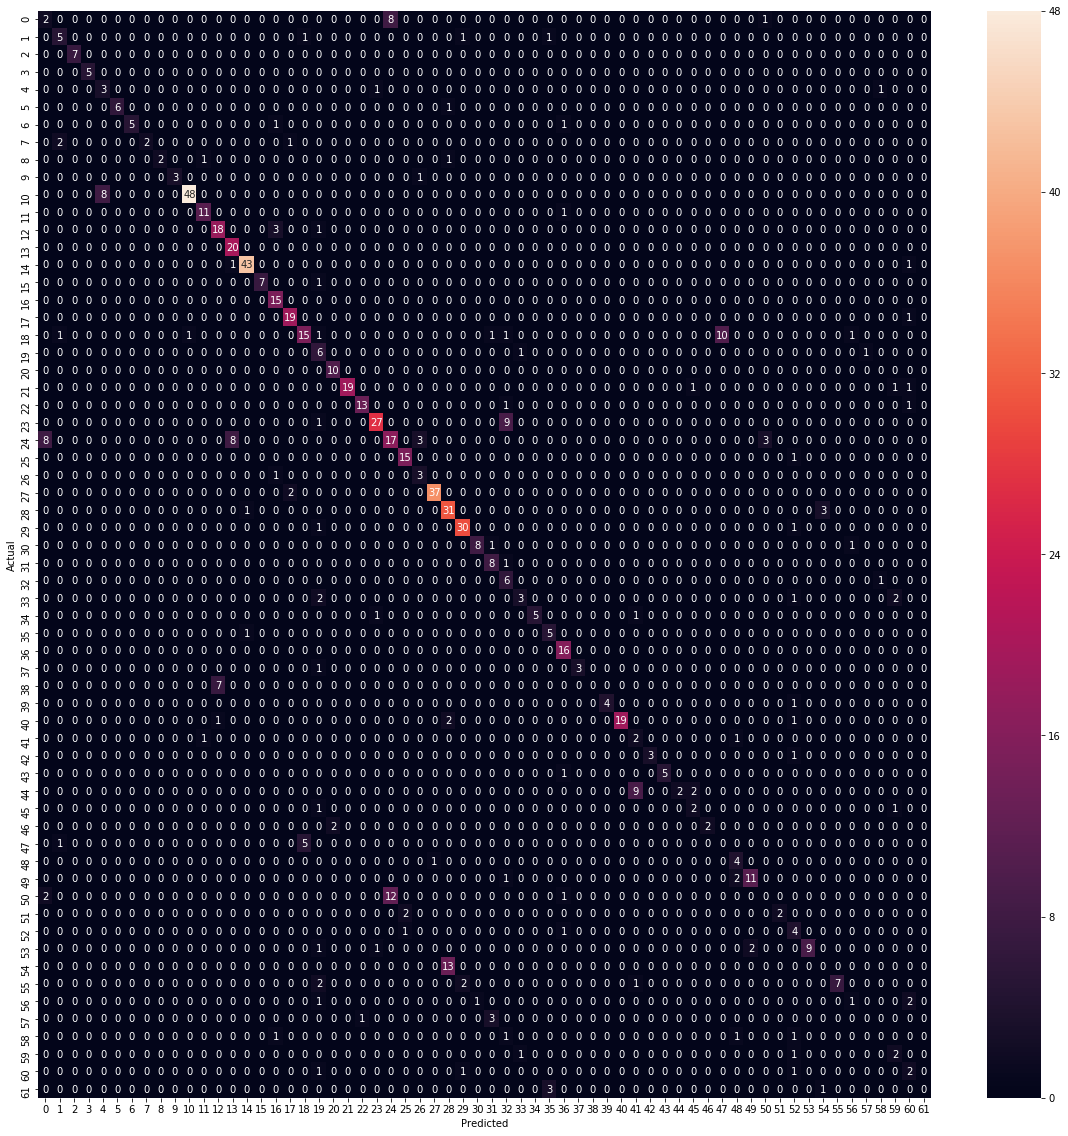

In [23]:
import seaborn as sns
y_test = np.argmax(Y_test_all, axis=1)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test,test_predictions)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [24]:
class_list = ["0","01", "02", "03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19","20", "21", "22","23","24","25","26","27","28","29","30","31","32","33","34","35","36","37","38","39","40","41","42","43","44","45","46","47","48","49","50","51","52","53","54","55","56","57","58","59","60","61"]
from sklearn import metrics
print(metrics.classification_report(y_test, test_predictions, target_names=class_list))

             precision    recall  f1-score   support

          0       0.17      0.18      0.17        11
         01       0.56      0.62      0.59         8
         02       1.00      1.00      1.00         7
         03       1.00      1.00      1.00         5
         04       0.27      0.60      0.37         5
         05       1.00      0.86      0.92         7
         06       1.00      0.71      0.83         7
         07       1.00      0.40      0.57         5
         08       1.00      0.50      0.67         4
         09       1.00      0.75      0.86         4
         10       0.98      0.86      0.91        56
         11       0.85      0.92      0.88        12
         12       0.69      0.82      0.75        22
         13       0.69      1.00      0.82        20
         14       0.96      0.96      0.96        45
         15       1.00      0.88      0.93         8
         16       0.71      1.00      0.83        15
         17       0.86      0.95      0.90   

### Show examples of images with model predictions

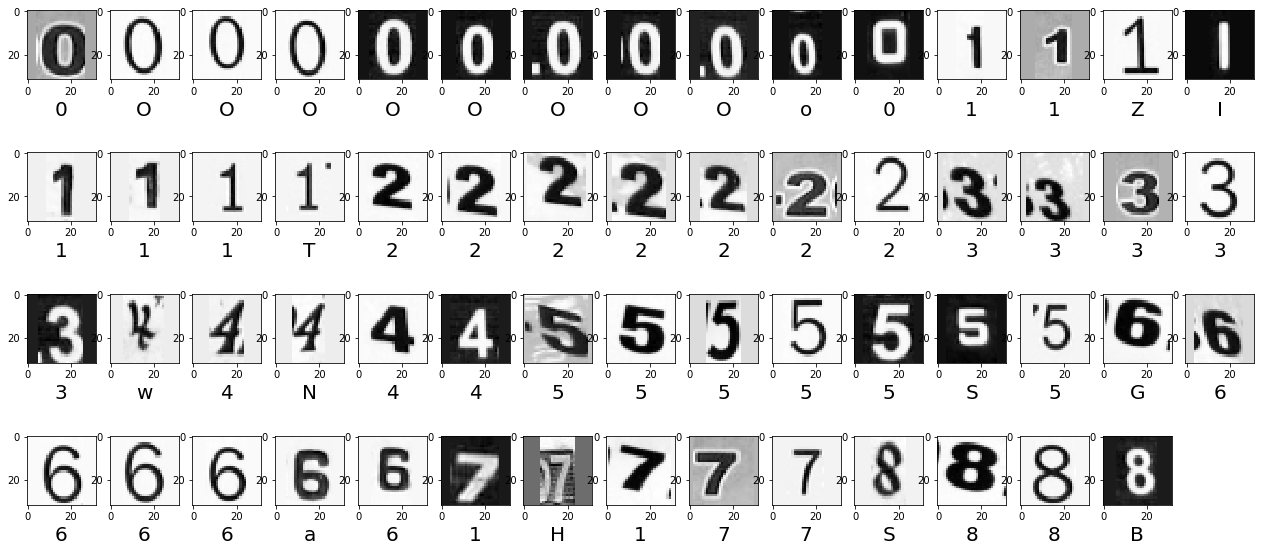

In [25]:
Y_test = np.argmax(Y_test_all, axis=1)

images = []
for img_path in sorted(glob.glob('data/test_preproc_32_32/img00*-*.png')):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(22,10))
columns = 15
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.xlabel(vs.int2label(test_predictions[i]),fontsize=20)
    plt.imshow(image, cmap='Greys_r')

### Model performance

The final accuracy of this initial exploratory model with the architecture below was around **71%** with an F1-score of **69%**. This was at 100 epochs and the model seemed like it would continue to learn further. 

* Conv2D: 3x3 kernels | 128 maps | init='he_normal' | relu | input shape = (1,32,32) 
* Conv2D: 3x3 kernels | 128 maps | init='he_normal' | relu 
* MaxPooling2D | 2x2 pool size 
* Conv2D: 3x3 kernels | 256 maps | init='he_normal' | relu 
* Conv2D: 3x3 kernels | 256 maps | init='he_normal' | relu 
* MaxPooling2D | 2x2 pool size |
* Conv2D: 3x3 kernels | 512 maps | init='he_normal' | relu 
* Conv2D: 3x3 kernels | 512 maps | init='he_normal' | relu 
* Conv2D: 3x3 kernels | 512 maps | init='he_normal' | relu (added after)
* MaxPooling2D | 2x2 pool size | 
* Flatten layer
* Fully Connected | 2048 units | relu
* Dropout (0.5)
* Fully Connected | 2048 units | relu
* Dropout (0.5)
* Fully Connected | 62 units | softmax 

Adding the extra  Conv2Dlayer in the final convolution block improved the performance over 100 epochs to **76%** with an F1 score of **72%** so we will stick with this. I ran this for 200 epochs but we could maybe run the model for only 100 epochs. 

### References

1. http://ankivil.com/kaggle-first-steps-with-julia-chars74k-first-place-using-convolutional-neural-networks/
2. https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
3. http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/
4. https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085
5. http://cs231n.github.io/convolutional-networks/#architectures
6. https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/